In [ ]:
import torch
from torch import nn, onnx
from torch.nn import functional as F
from torch.optim import Adam
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt

In [ ]:
def normalize(table: pd.Series) -> torch.Tensor:
    table = table.apply(lambda x: int(x.replace("#", "").replace("\ufeff", "")))
    table = torch.from_numpy(table.to_numpy())

    # От куда я взял эти числа смотри в analis.ipynb
    table[table < -1192] = -1192
    table[table >  1217] =  1217
    table = table - 10.31
    table = table / 1206.7

    return table

In [ ]:
def dec2bin(x: torch.Tensor, bits: int) -> torch.Tensor:
    mask = 2 ** torch.arange(bits-1, -1, -1).to(x.device, x.dtype)
    return x.unsqueeze(-1).bitwise_and(mask).ne(0)

def bin_coding(fen: str) -> torch.Tensor:
    fen, tour = fen.split(" ")[:2]
    fen = fen.replace("/", "")\
        .replace("1", ".")\
        .replace("2", "..")\
        .replace("3", "...")\
        .replace("4", "....")\
        .replace("5", ".....")\
        .replace("6", "......")\
        .replace("7", ".......")\
        .replace("8", "........")
    hot = torch.zeros(65, dtype=torch.uint8)

    for idx, sym in enumerate(fen):
        if sym == ".": continue
        elif sym == "r": hot[idx] = 1
        elif sym == "n": hot[idx] = 2
        elif sym == "b": hot[idx] = 3
        elif sym == "q": hot[idx] = 4
        elif sym == "k": hot[idx] = 5
        elif sym == "p": hot[idx] = 6
        elif sym == "R": hot[idx] = 7
        elif sym == "N": hot[idx] = 8
        elif sym == "B": hot[idx] = 9
        elif sym == "Q": hot[idx] = 10
        elif sym == "K": hot[idx] = 11
        elif sym == "P": hot[idx] = 12

    if tour == "b": hot[64] = 10  # 0b1010
    else: hot[64] = 5             # 0b0101

    return dec2bin(hot, 4).flatten()

def parse_fen(table: pd.Series) -> torch.Tensor:
    x = []

    for fen in tqdm(table, "Parse FEN"):
        x.append(bin_coding(fen))

    return torch.stack(x)

In [ ]:
def read_data(path: str,
              batch: int = 64,
              device: str = "cpu") -> "generator":
    table = pd.read_csv(path)
    fen = parse_fen(table.FEN).to(device).float()  # Очень долго
    eva = normalize(table.Evaluation).to(device)

    rand = torch.randperm(fen.size(0))
    fen = fen[rand]
    eva = eva[rand]
    max_n = round(fen.shape[0] / batch + 0.5)
    n = 0

    while True:
        if (n == max_n):
            rand = torch.randperm(len(fen))
            fen = fen[rand]
            eva = eva[rand]
            n = 0
        else:
            n += 1

        x = fen[batch * n:batch * (n + 1)]
        y = eva[batch * n:batch * (n + 1)]
        yield (x, y)

In [ ]:
class ChessAI(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(260, 30, bias=False), nn.ReLU(),
            nn.Linear( 30, 15, bias=False), nn.ReLU(),
            nn.Linear( 15,  5, bias=False), nn.ReLU(),
            nn.Linear(  5,  1, bias=False), nn.Softsign(),
        )

    def forward(self, inp: torch.Tensor) -> torch.Tensor:
        out = self.fc(inp)
        return out.squeeze(-1)

In [ ]:
def train(model: ChessAI,
          optimizer: Adam,
          data: "generator",
          loops: int = 64) -> list[float]:
    model.train()
    history = []

    for _ in tqdm(range(loops), "Train model"):
        x, y = next(data)
        out = model(x)
        loss = F.mse_loss(out, y)

        loss.backward()
        optimizer.step()
        model.zero_grad()

        history.append(loss.item())

    plt.plot(history)
    return history

In [ ]:
bot = ChessAI().to("cuda")
optim = Adam(
    bot.parameters(),
    lr=1e-4,
)
data = read_data(
    path="/content/drive/MyDrive/data/chessEval/random_evals.csv",
    batch=128,
    device="cuda",
)
next(data)

num_param = sum(p.numel() for p in bot.parameters())
print(f"Number parameters in Model: {num_param}")
print(bot)

Parse FEN: 100%|██████████| 1000273/1000273 [03:32<00:00, 4715.54it/s]


Number parameters in Model: 8330
ChessAI(
  (fc): Sequential(
    (0): Linear(in_features=260, out_features=30, bias=False)
    (1): ReLU()
    (2): Linear(in_features=30, out_features=15, bias=False)
    (3): ReLU()
    (4): Linear(in_features=15, out_features=5, bias=False)
    (5): ReLU()
    (6): Linear(in_features=5, out_features=1, bias=False)
    (7): Softsign()
  )
)


Train model: 100%|██████████| 131072/131072 [03:35<00:00, 609.43it/s]


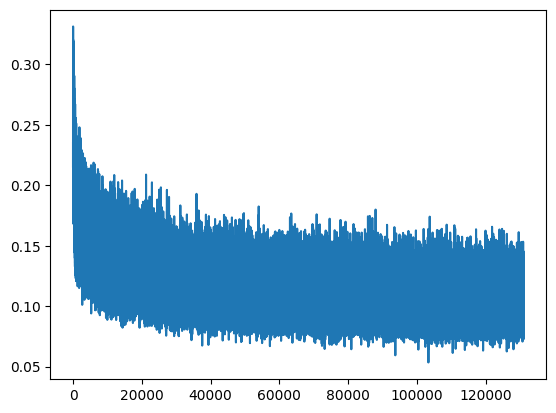

In [ ]:
hist = train(
    model=bot,
    optimizer=optim,
    data=data,
    loops=2**17,
)

In [ ]:
# Сохранение модели в формате onnx
bot.eval().cpu()
input = torch.zeros(1, 260)

onnx.export(
    model = bot,
    args = input,
    f = "ChessBot.onnx",
    export_params = True,
    verbose = True,
    input_names = ["Input"],
    output_names = ["Position assessment"],
    opset_version = 11,
)